Elaborado por Francy Liliana Camacho
Septiembre 26 de 2018


## Facturedo

### Del problema a un primera propuesta

#### ENTENDIMIENTO DEL PROBLEMA

Facturedo es una plataforma de financiación alternativa para empresas la cual basa sus operaciones en la compra y venta de facturas, conectando cedentes (empresas que quieren adelantar sus cuentas por cobrar) con inversionistas calificados. La manera de operar es la siguiente: una empresa cedente llega a Facturedo buscando financiación y para ello crea una operación a través de la plataforma donde ingresa toda la información referente a la o las facturas (cuentas por cobrar) que quiere vender para adelantar capital, ingresa información del deudor de esas facturas y su relación con él, una vez ha subido esta información a la plataforma deberá esperar que un integrante del equipo de operaciones de Facturedo valide la información y que se tome la decisión si esa operación es aceptada o rechazada y por tanto si tiene o no la posibilidad de recibir financiación que llega de un inversionista.

El problema a resolver a continuación es desarrollar un modelo predictivo que tome como referencia el dataset suministrado sobre el histórico de operaciones aceptadas o rechazadas y pueda determinar de manera automática, para una próxima operación que llegue, a cuál de las dos clases pertenecerá, es decir si será una operación aceptada o rechazada.

#### PROPUESTA ANALÍTICA

El problema planteado es de clasificación porque se conocen qué transacciones han sido aceptadas o rechazadas. Debido a que el conjunto de datos es pequeño (299 muestras y 10 características), para algunos algoritmos de machine learning resulta no ser suficiente. Sin embargo, como sólo dispongo de esta muestra, asumo que éstos son representativos de la población. 

A partir de lo anterior, el proceso que se aplicará es el siguiente:

1. Análisis Exploratorio de Datos (EDA): para comprender el comportamiento de los datos a través de herramientas visuales.
2. Prueba estadística: para verificar si con los datos disponibles existe una diferenciación entre ambos grupos. Como tengo 10 características, aplicaré PCA para comprimir la información en un número mucho menor de características. Esto está sujeto, claro está, si luego de realizar el EDA no existen diferenciaciones visuales entre ambos grupos.
3. Algoritmo de aprendizaje: depende de los resultados que se obtengan de los dos puntos anteriores y por el tamaño de la muestra, pueden aplicarse Regresión logística, Naive Bayes, Random forest, por nombrar algunas. Más adelante se indicará qué algoritmo se usará.

#### Variables disponibles

* operation_id: Es un id único para cada operación que se sube a la plataforma [incremento].
* amount: Hace referencia a la cantidad de dinero que suman las facturas que se quieren financiar y corresponde al monto pendiente de pago por parte del deudor [USD]
* payment_method: Método de pago usado por el deudor [transferencia bancaria o cheque]
* anual_sales_volume: Hace referencia al volumen anual de ventas de la empresa cedente con el cliente deudor [USD].
* mean_time: Hace referencia al tiempo de pago promedio al que difiere el deudor la cantidad prestada con el cedente [30 días, 60 días, 90 días, 120 días]
* invoice_mean_val: Está asociado con el monto promedio de las facturas (monto promedio de las deudas) de la empresa deudora [menos de USD 1000, Entre USD 1000 y USD 5000, Entre USD 5000 y USD 20000, Entre USD 20000 y USD 100000, Más de USD 100000]
* entity_type: Es el tipo de empresa deudora [persona natural o persona jurídica]
* relationship_years: Número de años de relación entre la empresa cedente y deudora
* creation_date: Fecha en la que fue creada la operación en la plataforma por parte del deudor [date]
* payment_date: Fecha en la que se espera que el deudor realice el pago de la operación [date]
* city: Ciudad donde se encuentra ubicada la empresa deudora [ciudades de Perú con valores entre 1 y 23]

### Recolección de datos


In [25]:
# Carga las librerías
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.decomposition import PCA
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
## Función para graficar las curvas de aprendizaje para los algoritmos de machine learning.
## Esta se usa para identificar problemas como alto sesgo y alta varianza.
## Tomado de http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
#Carga los archivos
train = pd.read_csv('test_data_set.csv', encoding='utf8')

#Remueve los caracteres especiales porque suponen un problema para tratarlos
train['entity_type'] = train['entity_type'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
train['mean_time'] = train['mean_time'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
train['invoice_mean_val'] = train['invoice_mean_val'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
train['payment_method'] = train['payment_method'].str.replace("'","") 

#Convierte a formato fecha las columnas creation_date y payment_date
train['creation'] = pd.to_datetime(train.creation_date, format='%d/%m/%Y')  
train['payment'] = pd.to_datetime(train.payment_date, format='%d/%m/%Y')  

train.head()

,operation_id,amount,payment_method,anual_sales_volume,mean_time,invoice_mean_val,entity_type,relationship_years,creation_date,payment_date,city,industry,result,creation,payment
0,1,18714.00,cheque,391000,90 dias,Entre USD 5000 y USD 20000,persona natural,5,4/12/2017,14/2/2018,20,9,Aceptada,2017-12-04,2018-02-14
1,2,1596.00,cheque,33000,60 dias,Menos de USD 1000,persona juridica,7,2/8/2018,13/9/2018,11,12,Aceptada,2018-08-02,2018-09-13
2,3,19152.00,cheque,409000,30 dias,Entre USD 20000 y USD 100000,persona natural,1,28/8/2018,7/12/2018,12,10,Aceptada,2018-08-28,2018-12-07
3,4,6354.00,cheque,68000,90 dias,Entre USD 5000 y USD 20000,persona juridica,8,16/7/2018,9/11/2018,17,5,Aceptada,2018-07-16,2018-11-09
4,5,9729.72,cheque,214000,120 dias,Entre USD 20000 y USD 100000,persona natural,3,27/5/2018,23/9/2018,7,15,Aceptada,2018-05-27,2018-09-23


In [4]:
## Tamaño del conjunto de datos
train.shape

(299, 15)

### Del entendimiento a la preparación

**  Análisis Exploratorio de Datos**

In [5]:
## Identifica si existe valores nulos
print "-----Training set-----"
print train.isnull().sum()

-----Training set-----
operation_id          0
amount                0
payment_method        0
anual_sales_volume    0
mean_time             0
invoice_mean_val      0
entity_type           0
relationship_years    0
creation_date         0
payment_date          0
city                  0
industry              0
result                0
creation              0
payment               0
dtype: int64


In [6]:
## Verifica si existen filas duplicadas
print "Train: ", train.drop_duplicates().shape

Train:  (299, 15)


In [7]:
## Distribución numérica de la variable de interés
print "---Trainset---"
acept_perc =(train[train['result']=='Aceptada'].shape[0]/float(train.shape[0]))
print "% transacciones aprobadas {:2.2%}".format(acept_perc)
print "% transacciones rechazadas {:2.2%}".format(1-acept_perc)

---Trainset---
% transacciones aprobadas 58.53%
% transacciones rechazadas 41.47%


Las clases no tienen un desbalanceo fuerte, por lo que no es necesario aplicar ningún tratamiento previo.

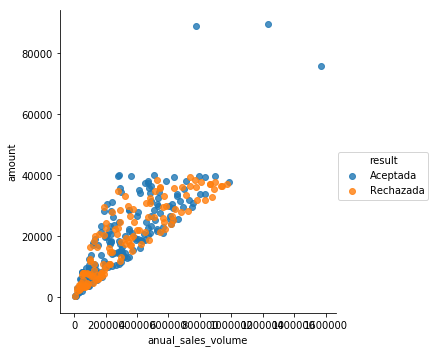

In [8]:
## Identifica si existen outliers
sns.lmplot(x='anual_sales_volume',y='amount',data=train,hue='result', fit_reg=False)

Existen 3 valores extremos, que pueden afectar el desempeño del clasificador, por ende se toma la decisión de removerlos. 


In [9]:
## Remueve los valores atípicos
train = train[train['amount']<60000]

Se plantean diversas visualizaciones con el fin de dar respuesta a una serie de preguntas (intuiciones acerca de los datos).

* ¿El método de pago y la cantidad son condición para que una transacción sea aceptada o rechazada?

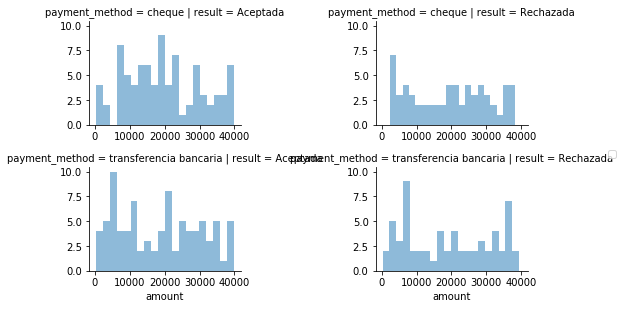

In [10]:
grid = sns.FacetGrid(train, col='result', row='payment_method', size=2.2, aspect=1.6)
grid.map(plt.hist, 'amount', alpha=.5, bins=20)
grid.add_legend();

No parece haber una preferencia en el método de pago para que sea aceptada o rechazada una transacción.

* ¿El tipo de persona y la cantidad son condición para que una transacción sea aceptada o rechazada?

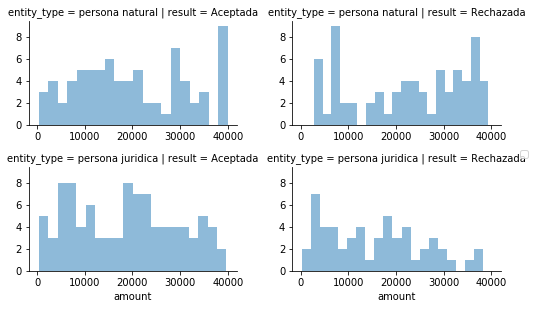

In [11]:
grid = sns.FacetGrid(train, col='result', row='entity_type', size=2.2, aspect=1.6)
grid.map(plt.hist, 'amount', alpha=.5, bins=20)
grid.add_legend();

En las transacciones rechazadas, para valores altos hay un mayor número de rechazos comparado con la persona jurídica.

* ¿Existe alguna relación entre mean_time, invoice_mean_val y el tipo de transacción?

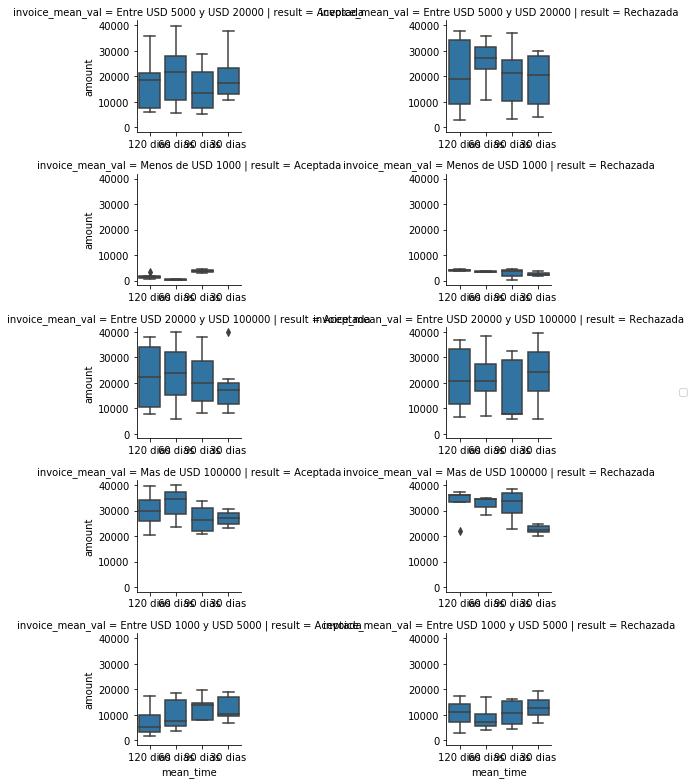

In [12]:
grid = sns.FacetGrid(train, row='invoice_mean_val', col='result', size=2.2, aspect=1.6)
grid.map(sns.boxplot, 'mean_time', 'amount')
grid.add_legend()

Visualmente no parece haber una discriminación con las variables analizadas. Hay pequeñas diferencias, por ejemplo, en el invoice_mean_val = Mas de USD 100000 y el plazo de 30 días, pero en general, las distribuciones se solapan.

* ¿Los años de relación o el tipo de industria afecta el tipo de transacción? 

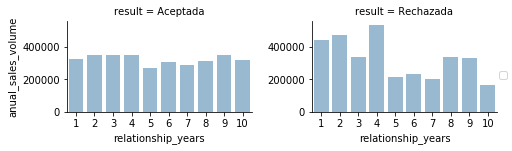

In [13]:
grid = sns.FacetGrid(train, col='result', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'relationship_years', 'anual_sales_volume', alpha=.5, ci=None)
grid.add_legend()

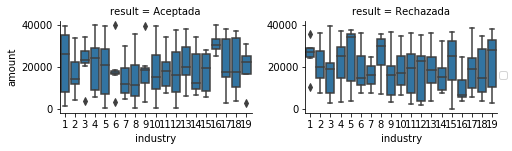

In [14]:
grid = sns.FacetGrid(train, col='result', size=2.2, aspect=1.6)
grid.map(sns.boxplot, 'industry', 'amount')
grid.add_legend()

El comportamiento es más uniforme en las transacciones aceptadas, pero en general no es un factor discriminante.  Sin embargo, en la industria 8 hay una preferencia por aceptar facturas por debajo de los 25000 y en la industria 16 se rechazan las facturas con montos inferiores a los 15000.

### Feature engineering

In [15]:
#Convierte a dias la diferencia entre el tiempo de creación y de pago
train['delta'] = pd.to_timedelta(train.payment-train.creation, unit='d').dt.days

In [16]:
# Convertimos las características categóricas a numéricas 
train['payment_method'] = train['payment_method'].map( {'cheque': 0, 'transferencia bancaria': 1} ).astype(int)
train['mean_time'] = train['mean_time'].map( {'30 dias': 0, '60 dias': 1,'90 dias': 2, '120 dias': 3} ).astype(int)
train['invoice_mean_val'] = train['invoice_mean_val'].map( {'Menos de USD 1000': 0, 'Entre USD 1000 y USD 5000': 1,'Entre USD 5000 y USD 20000': 2, 'Entre USD 20000 y USD 100000': 3, 'Mas de USD 100000':4} ).astype(int)
train['entity_type'] = train['entity_type'].map( {'persona natural': 0, 'persona juridica': 1} ).astype(int)
train['result'] = train.result.map({'Aceptada':0,'Rechazada':1})

In [17]:
train.head()

,operation_id,amount,payment_method,anual_sales_volume,mean_time,invoice_mean_val,entity_type,relationship_years,creation_date,payment_date,city,industry,result,creation,payment,delta
0,1,18714.00,0,391000,2,2,0,5,4/12/2017,14/2/2018,20,9,0,2017-12-04,2018-02-14,72
1,2,1596.00,0,33000,1,0,1,7,2/8/2018,13/9/2018,11,12,0,2018-08-02,2018-09-13,42
2,3,19152.00,0,409000,0,3,0,1,28/8/2018,7/12/2018,12,10,0,2018-08-28,2018-12-07,101
3,4,6354.00,0,68000,2,2,1,8,16/7/2018,9/11/2018,17,5,0,2018-07-16,2018-11-09,116
4,5,9729.72,0,214000,3,3,0,3,27/5/2018,23/9/2018,7,15,0,2018-05-27,2018-09-23,119


Revisamos si existe una correlación entre las características. Esta es una condición importante porque muchos algoritmos de aprendizaje asumen independencia entre las características.

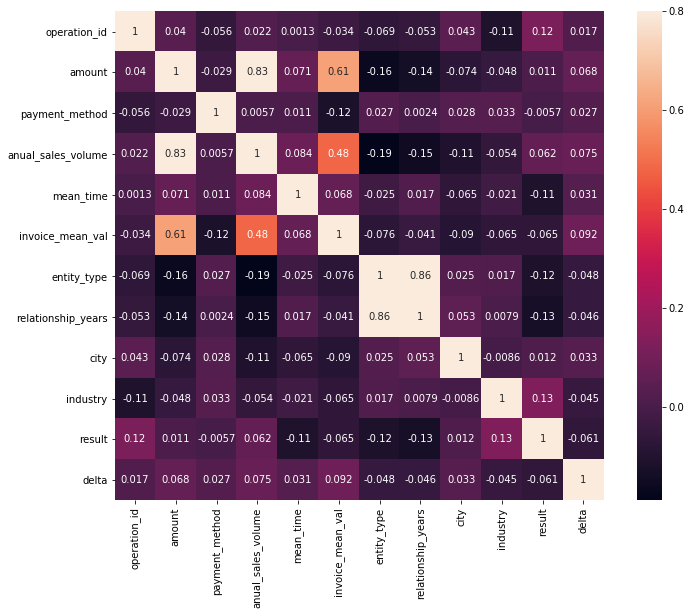

In [18]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True,vmax=.8, square=True);

En este caso, se observa que existe una fuerte correlación entre la variable amount y annual_sales_volume (como era de esperarse, porque a mayor valor de las facturas a su vez incrementa el volumen de ventas) y entre la variable entity_type y relationship_years. Para esta última, se hace una visualización para comprender mejor esta relación. 

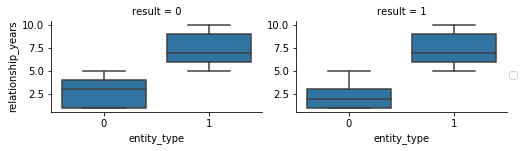

In [19]:
grid = sns.FacetGrid(train, col='result', size=2.2, aspect=1.6)
grid.map(sns.boxplot, 'entity_type', 'relationship_years')
grid.add_legend()

Si bien se observa que el número de años de relación con la persona jurídica es mayor que con la persona natural, al graficarlas contra la variable de interés no hay ninguna diferencia.

In [20]:
## Se extrae la variable dependiente y se almacena en y_train
y_train = train.result

# Se eliminan las características que no se requieren
train.drop(['operation_id','creation_date','payment_date','creation','payment','result','anual_sales_volume','entity_type'],axis=1,inplace=True)

Antes de aplicar algún algoritmo, uso PCA para comprimir la información de las 10 características en 3 componentes y las visualizo.

In [21]:
pca = PCA(n_components=3)
n_train = pca.fit_transform(train)

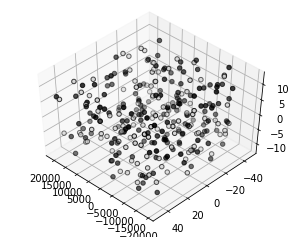

In [22]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# Reorder the labels to have colors matching the cluster results
#y = np.choose(y_real, [1, 2, 0]).astype(np.float)
ax.scatter(n_train[:, 0], n_train[:, 1], n_train[:, 2], c=y_train, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

No se observa una diferenciación entre ambos grupos. Con el fin de validar estadísticamente, si existen o no diferencias, se aplica una prueba de hipótesis con un valor p de 0.05.

In [23]:
# Prueba de hipótesis para la diferencia de medias usando la t student
# H0: u1=u=2, H1: u1!=u2
# p = 0.05
# Como no conozco la varianza de las poblaciones, el mejor escenario es asumir que son diferentes.
stats.ttest_ind(n_train[y_train==0][:,0], n_train[y_train==1][:,0], equal_var = False)

Ttest_indResult(statistic=-0.1811387315293148, pvalue=0.8563997576694133)

En este caso, como el p_value es mayor a 0.05 no hay suficiente evidencia para rechazar la hipótesis nula (que ambos grupos tienen medias iguales). Esto parece indicar que estas características no logran discenir entre ambos grupos. Sin embargo, decido aplicar Random Forest porque funciona bien en un gran conjunto de datos y que es menos propenso al overfitting comparado con los árboles de decisión. 

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Se crea el clasificador
clf = RandomForestClassifier()

#Se ajusta
clf.fit(train, y_train)

# Se establece el método de validación cruzada a usar
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#Se definen los parámetros libres a variar
n_estimators = [10,20,30]
param_grid = {'n_estimators': n_estimators}

# Se hace un grid search para buscar los parámetros libres que ofrecen los mejores resultados
tune_model = model_selection.GridSearchCV(clf, param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(train, y_train)

print('Parámetros con los mejores resultados: ', tune_model.best_params_)
print("Score promedio en el conjunto de entrenamiento: {:.2f}". format(tune_model.cv_results_['mean_train_score'].mean()*100)) 
print("Score promedio en el conjunto de test: {:.2f}". format(tune_model.cv_results_['mean_test_score'].mean()*100)) 


/anaconda2/lib/python2.7/site-packages/sklearn/tree/tree.py:40: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._criterion import Criterion
/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._gradient_boosting import predict_stages


('Par\xc3\xa1metros con los mejores resultados: ', {'n_estimators': 20})
Score promedio en el conjunto de entrenamiento: 99.95
Score promedio en el conjunto de test: 53.44


/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


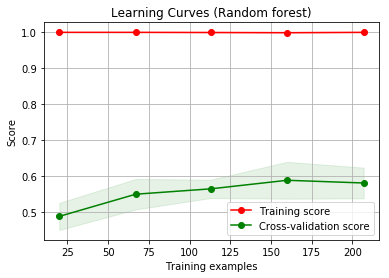

In [26]:
## Debido a la amplia diferencia entre el conjunto de test y de entrenamiento, es un indicio 
## de que el modelo sufre de overfiting. Para verlo gráficamente se usan las curvas de
# aprendizaje.

title = "Learning Curves (Random forest)"
cv = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

plot_learning_curve(tune_model, title, train, y_train, cv=cv, n_jobs=4)
plt.show()

Los resultados muestran que el algoritmo sufre de overfitting, por lo que podria probar varias estrategias:

* Incluir más datos de entrenamiento - no es posible, sólo cuento con esa muestra.
* Reducir el número de características - son sólo 10 características, no creo pertinente hacerlo.
* Incrementar el parámetro de reguralización. Como tal, random forest previene el overfiting en la mayoría de los casos, pero para éste en particular no parece funcionar.

## Conclusiones

1. Se requieren más datos para poder aplicar otras técnicas de aprendizaje.
2. Para realizar una ingeniería de características más sólida, se requiere conocer mejor el problema y comprender en más detalle cómo se acepta o rechaza una transacción, porque con las 10 variables no es suficiente.
3. Existen algoritmos como Xgboost que se usan frecuentemente para diferentes tipos de datasets (es el más usado en las competencias de Kaggle), sin embargo, es necesario obtener más datos y más variables para explotar el potencial de dicho algoritmo.


## Siguientes pasos
1. Aplicar K-Means (n_clusters=2) con el fin de evaluar si los datos asignados a los dos grupos, corresponden a los que indica la variable result.
2. Aumentar el número de características.
3. Aplicar la prueba de hipótesis nuevamente.
4. Aplicar un algoritmo sencillo (regresión logística) y uno mucho más complejo como Xgboost para ver el comportamiento de ambos.